In [1]:
import torch
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

import numpy as np
import random
import os
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [15]:
model = resnet50()
model.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 2),
    torch.nn.Softmax(dim=1)
)
model.load_state_dict(torch.load("/home/dilith/Projects/monkeypox/models/model_bin_1_49.pt"))
model = model.to(device)

In [16]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.Resize((224, 224)),
])

In [17]:
image_path = glob("/home/dilith/Projects/monkeypox/data/combined/monkeypox/*")[0]
# image_path = "/home/dilith/Projects/monkeypox/data/combined/monkeypox/Moneypox_3.jpg"

pil_image = Image.open(image_path)
image = transform(pil_image)
pil_image = pil_image.resize((224, 224))

disease = os.path.basename(os.path.dirname(image_path))

image = image.to(device).unsqueeze(dim=0)
image.requires_grad_()

scores = model(image).squeeze()
print(scores)
scores.backward()

saliency, _ = torch.max(image.grad.data.abs(),dim=1)

tensor([1.0000e+00, 5.4632e-07], device='cuda:0', grad_fn=<SqueezeBackward0>)


RuntimeError: grad can be implicitly created only for scalar outputs

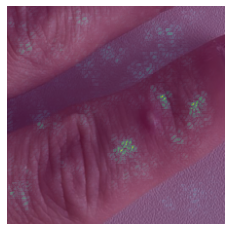

In [39]:
plt.imshow(np.asarray(pil_image))
plt.imshow(saliency.cpu()[0], alpha=0.5)
plt.axis('off')
plt.show()